In [1]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embeddings_model = OpenAIEmbeddings(model='text-embedding-3-small')

menu_db = Chroma(
    embedding_function=embeddings_model,
    collection_name='restaurant_menu',
    persist_directory='./chroma_db'
)

menu_retriever = menu_db.as_retriever(
    search_kwargs={'k': 2}
)

query = '시그니처 스테이크의 가격과 특징은 무엇인가요?'
docs = menu_retriever.invoke(query)
print(f'검색 결과: {len(docs)}개')


Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given


검색 결과: 2개


In [2]:
wine_db = Chroma(
    embedding_function=embeddings_model,
    collection_name='restaurant_wine',
    persist_directory='./chroma_db'
)

wine_retriever = wine_db.as_retriever(
    search_kwargs={'k': 2}
)

query = '스테이크와 어울리는 와인을 추천해주세요'
docs = wine_retriever.invoke(query)
print(f'검색 결과: {len(docs)}개')

Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given


검색 결과: 2개


In [ ]:
from langgraph.graph import MessagesState
from typing import List
from langchain_core.documents import Document

class GraphState(MessagesState):
    # messages 키를 기본적으로 제공
    documents: List[Document]
    grade: float
    num_generation: int
    last_user_message: str

In [4]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

# LLM 모델 
llm = ChatOpenAI(model="gpt-4o-mini")

# RAG 체인 구성
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

system = """
You are a helpful assistant. Use the following context to answer the user's question:

[Context]
{context}
"""

prompt = ChatPromptTemplate.from_messages([
    ("system", system),
    ("human", "{question}")
])

# 검색기 정의
retriever = menu_db.as_retriever(
    search_kwargs={"k": 2}
)

# RAG 체인 구성
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

# RAG 체인 실행
query = "채식주의자를 위한 메뉴를 추천해주세요."
response = rag_chain.invoke(query)

# 답변 출력
print(response)

제공된 메뉴에는 채식주의자를 위한 옵션이 포함되어 있지 않습니다. 하지만, 연어 타르타르와 같은 메뉴는 해산물이 포함되어 있으므로 채식주의자에게는 적합하지 않습니다. 만약 채식 메뉴가 필요하시다면, 별도로 채식 옵션을 요청하시거나 다른 메뉴를 참고하시는 것이 좋습니다.


In [ ]:
from langchain_core.messages import AIMessage, HumanMessage

# RAG 수행 함수 정의
def retrieve_and_respond(state: GraphState):
    # last_human_message = state['messages'][-1]
    # print('state[messages]: ',state['messages'])
    # print('ㄴㄴㄴ', last_human_message['HumanMessage'])
    if "last_user_message" not in state:
        last_human_message = state['messages'][-1]
        query = last_human_message.content
        state["last_user_message"] = query
    else:
        query = state["last_user_message"]

    # HumanMessage 객체의 content 속성에 접근
    query = last_human_message.content
    
    # 문서 검색
    retrieved_docs = retriever.invoke(query)
    
    # 응답 생성
    response = rag_chain.invoke(query)
    
    # 검색된 문서와 응답을 상태에 저장
    return {
        "messages": [AIMessage(content=response)],
        "documents": retrieved_docs
    }

In [ ]:
from pydantic import BaseModel, Field

class GradeResponse(BaseModel):
    "A score for answers"
    score: float = Field(..., ge=0, le=1, description="A score from 0 to 1, where 1 is perfect")
    explanation: str = Field(..., description="An explanation for the given score")

# 답변 품질 평가 함수
def grade_answer(state: GraphState):
    messages = state['messages']
    question = messages[-2].content
    answer = messages[-1].content
    context = format_docs(state['documents'])

    # grading_system = """You are an expert grader. 
    # Grade the following answer based on its relevance and accuracy to the question, considering the given context. 
    # Provide a score from 0 to 1, where 1 is perfect, along with an explanation."""

    grading_system = """ 
    당신은 전문가 채점자입니다. 당신의 임무는 두 가지를 모두 바탕으로 답을 **엄격히** 평가하는 것입니다:
    1. 질문과의 관련성
    2. 제공된 컨텍스트의 사용

    답변이 문맥을 적절히 활용하지 못하거나 문맥이 질문과 무관한 경우, 답변이 정중하거나 합리적으로 보일지라도 **낮은 점수**를 주세요. 
    question 내용에서 context에 없는 메뉴를 찾으면 특히 낮은 점수를 주세요.
    answer 내용에 "정보가 없습니다" 내용이 있으면 더 낮은 점수를 주세요.
    답변이 반복적이거나 관련 응답을 여러 번 제공하지 않는 경우 **점수를 벌점**해야 합니다.
    답변이 "맥락은 관련이 없다"고 인정하더라도, 제공된 문맥을 사용하지 않았기 때문에 **낮은 점수** (≤ 0.3)를 주어야 합니다.

    문맥이 직접적으로 뒷받침하지 않는 한 정중한 거절이나 반복적인 답변에 대해 높은 점수를 주지 마세요.

    다음 규칙을 사용하세요:
    - 문맥을 이용한 완벽한 답변: 1.0
    - 부분적으로 올바르지만 모호한 문맥 사용: 0.5–0.7
    - 답변이 컨텍스트를 사용하지 않거나 전혀 사용할 수 없습니다: 0.0–0.3
    """

    grading_prompt = ChatPromptTemplate.from_messages([
        ("system", grading_system),
        ("human", "[Question]\n{question}\n\n[Context]\n{context}\n\n[Answer]\n{answer}\n\n[Grade]\n")
    ])
    
    grading_chain = grading_prompt | llm.with_structured_output(schema=GradeResponse)
    
    grade_response = grading_chain.invoke({
        "question": question,
        "context": context,
        "answer": answer
    })

    # 답변 생성 횟수를 증가 
    num_generation = state.get('num_generation', 0)
    num_generation += 1 
    
    return {"grade": grade_response.score, "num_generation": num_generation}

In [7]:
from typing import Literal


def should_retry(state: GraphState) -> Literal["retrieve_and_respond", "generate"]:
    print("----GRADTING---")
    print("Grade Score: ", state["grade"])

    # 답변 생성 횟수가 3회 이상이면 "generate"를 반환
    if state["num_generation"] > 2: 
        return "generate"    
    
    # 답변 품질 평가점수가 0.7 미만이면 RAG 체인을 다시 실행 
    if state["grade"] < 0.7:  
        return "retrieve_and_respond"
    else:
        return "generate"

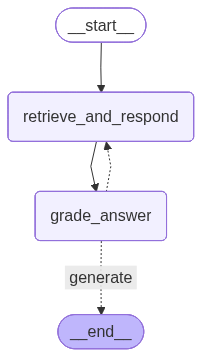

In [8]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
from IPython.display import Image, display

# 그래프 설정
builder = StateGraph(GraphState)
builder.add_node("retrieve_and_respond", retrieve_and_respond)
builder.add_node("grade_answer", grade_answer)

builder.add_edge(START, "retrieve_and_respond")
builder.add_edge("retrieve_and_respond", "grade_answer")
builder.add_conditional_edges(
    "grade_answer",
    should_retry,
    {
        "retrieve_and_respond": "retrieve_and_respond",
        "generate": END
    }
)

# 그래프 컴파일
graph = builder.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
# 초기 상태
initial_state = {
    "messages": [HumanMessage(content="마기꾼.")],
}

# 그래프 실행 
final_state = graph.invoke(initial_state)

# 최종 상태 출력
print("최종 상태:", final_state)

state[messages]:  [HumanMessage(content='마기꾼.', additional_kwargs={}, response_metadata={}, id='debdd05b-40cf-4758-add7-70732b2f855e')]
----GRADTING---
Grade Score:  0.0
state[messages]:  [HumanMessage(content='마기꾼.', additional_kwargs={}, response_metadata={}, id='debdd05b-40cf-4758-add7-70732b2f855e'), AIMessage(content='"마기꾼"은 "마법사"나 "마법사 같은 사람"을 의미하는 단어로, 일반적으로 마법이나 특별한 능력을 가진 사람을 지칭하는 표현입니다. 혹시 더 구체적인 질문이나 정보가 필요하신가요?', additional_kwargs={}, response_metadata={}, id='b3dd206b-0769-407c-8fd6-b5e169f7b1f2')]
----GRADTING---
Grade Score:  0.5
state[messages]:  [HumanMessage(content='마기꾼.', additional_kwargs={}, response_metadata={}, id='debdd05b-40cf-4758-add7-70732b2f855e'), AIMessage(content='"마기꾼"은 "마법사"나 "마법사 같은 사람"을 의미하는 단어로, 일반적으로 마법이나 특별한 능력을 가진 사람을 지칭하는 표현입니다. 혹시 더 구체적인 질문이나 정보가 필요하신가요?', additional_kwargs={}, response_metadata={}, id='b3dd206b-0769-407c-8fd6-b5e169f7b1f2'), AIMessage(content='"마기꾼"이라는 단어에 대해 더 궁금한 점이 있으신가요? 예를 들어, 이 단어의 유래, 사용되는 문맥, 또는 관련된 문화적 요소에 대해 질문하시면 더